### Test a simple example of creating and using custom fitness, mutation, and fixation probability functions 
This notebook lays out the usage of the PathwaySetFlex object in *enzo*, which allows/requires the user to input custom functions to determine mutations, fitness, and fixation probability. The fitness function must be a function of either the steady state concentrations or the steady state amounts of floating species. Aside from that constraint, the user can input any arbitrary fitness function. The same goes for the mutation function and the fixation probability function. They are now very flexible. One important note is that I have now allowed the "mutation" values to be either 1) a multiplier that is applied to the previous parameter value at each iteration, or 2) a set of values that are directly assigned to the parameters. This is shown below in more detail. 

In [1]:
import numpy as np
import tellurium as te
%matplotlib inline
import matplotlib.pyplot as plt
from copy import copy
from enzo import PathwaySetFlex

### Define the antimony model 


In [2]:
# Create a model string to generate models downstream. This is the naive anthocyanin pathway model as used in 
# the original paper. Under the hood, this is passed to Tellurium to generate a model object. 
model_string = """
    
    # Constant source entering model
    Source: => PCoA;
    
    # Rate laws for all the central enzymatic reactions
    
    CHS: PCoA => cha; (k_CHS_PCoA*CHSt*PCoA)/(Km_CHS_PCoA + PCoA);
    
    CHI: cha => nar; (k_CHI_cha*CHIt*cha)/(Km_CHI_cha + cha);
    

    F3H_nar: nar => DHK; (k_F3H_nar*F3Ht*nar)/(Km_F3H_nar + nar);
    
    
    F3pH_DHK: DHK => DHQ; (k_F3pH_DHK*F3pHt*DHK)/(Km_F3pH_DHK + DHK);
    
    
    F35H_DHQ: DHQ => DHM; (k_F35H_DHQ*F35Ht*DHQ)/(Km_F35H_DHQ + DHQ);
    
    
    FLS_DHK: DHK => kam; (k_FLS_DHK*FLSt*DHK)/(Km_FLS_DHK * (1 + DHQ/Km_FLS_DHQ + DHM/Km_FLS_DHM) + DHK);
    
    FLS_DHQ: DHQ => que; (k_FLS_DHQ*FLSt*DHQ)/(Km_FLS_DHQ * (1 + DHM/Km_FLS_DHM + DHK/Km_FLS_DHK) + DHQ);
    
    FLS_DHM: DHM => myr; (k_FLS_DHM*FLSt*DHM)/(Km_FLS_DHM * (1 + DHK/Km_FLS_DHK + DHQ/Km_FLS_DHQ) + DHM);
    
    
    DFR_DHK: DHK => LCP; (k_DFR_DHK*DFRt*DHK)/(Km_DFR_DHK * (1 + DHQ/Km_DFR_DHQ + DHM/Km_DFR_DHM) + DHK);
    
    DFR_DHQ: DHQ => LCC; (k_DFR_DHQ*DFRt*DHQ)/(Km_DFR_DHQ * (1 + DHK/Km_DFR_DHK + DHM/Km_DFR_DHM) + DHQ);
    
    DFR_DHM: DHM => LCD; (k_DFR_DHM*DFRt*DHM)/(Km_DFR_DHM * (1 + DHK/Km_DFR_DHK + DHQ/Km_DFR_DHQ) + DHM);
    
    
    ANS_LCP: LCP => pel; (k_ANS_LCP*ANSt*LCP)/(Km_ANS_LCP * (1 + LCC/Km_ANS_LCC + LCD/Km_ANS_LCD) + LCP);
    
    ANS_LCC: LCC => cya; (k_ANS_LCC*ANSt*LCC)/(Km_ANS_LCC * (1 + LCP/Km_ANS_LCP + LCD/Km_ANS_LCD) + LCC);
    
    ANS_LCD: LCD => del; (k_ANS_LCD*ANSt*LCD)/(Km_ANS_LCD * (1 + LCP/Km_ANS_LCP + LCC/Km_ANS_LCC) + LCD);
    

    # Product sinks
    
    pel_sink: pel =>; k_pel_sink*pel;
    
    cya_sink: cya =>; k_cya_sink*cya;
    
    del_sink: del =>; k_del_sink*del;
    

    kam_sink: kam =>; k_kam_sink*kam;
    
    que_sink: que =>; k_que_sink*que;
    
    myr_sink: myr =>; k_myr_sink*myr;
    
        
    # Substrate Kcat's
    k_CHS_PCoA=14; k_CHI_cha=14; k_F3H_nar=14; 
    k_F3pH_DHK=14; k_F35H_DHQ=14; k_FLS_DHK=14; 
    k_FLS_DHQ=14; k_FLS_DHM=14; k_DFR_DHK=14; k_DFR_DHQ=14; k_DFR_DHM=14; k_ANS_LCP=14; k_ANS_LCC=14;
    k_ANS_LCD=14; 
   
    # Substrate Km's
    Km_CHS_PCoA=0.013; Km_CHI_cha=0.013; 
    Km_F3H_nar=0.013; Km_F3pH_DHK=0.013; Km_F35H_DHQ=0.013; 
    Km_FLS_DHK=0.013; Km_FLS_DHQ=0.013; Km_FLS_DHM=0.013; 
    Km_DFR_DHK=0.013; Km_DFR_DHQ=0.013; Km_DFR_DHM=0.013; 
    Km_ANS_LCP=0.013; Km_ANS_LCC=0.013; Km_ANS_LCD=0.013;


    # Enzyme concentrations
    CHSt=0.001; CHIt=0.001; F3Ht=0.001; F3pHt=0.001;
    F35Ht=0.001; FLSt=0.001; DFRt=0.001; ANSt=0.001; 

    
    # Rates for sinks 
    k_pel_sink=0.0005; k_cya_sink=0.0005; k_del_sink=0.0005; 
    k_kam_sink=0.0005; k_que_sink=0.0005; k_myr_sink=0.0005; 
    
    # Source influx
    const PCoA = 0.01;
"""

In [3]:
# Load the model_string into a Tellurium model object 
r = te.loada(model_string)

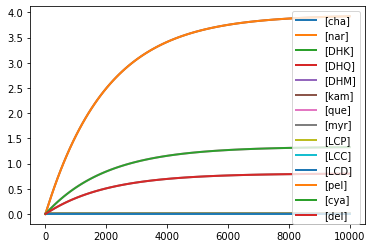

In [4]:
r.resetToOrigin()
result = r.simulate(1, 10000, 100)
r.plot()

In [5]:
# Get a named array of steady state values for the floating species
r.resetToOrigin()
r.getSteadyStateValuesNamedArray()

    [cha], [nar],      [DHK],       [DHQ],       [DHM],   [kam],   [que],    [myr],      [LCP],       [LCC],       [LCD],   [pel],   [cya],    [del]
 [[  0.01,  0.01, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526]]

In [6]:
# This array seems to be identical to the steady state solution array
r.getFloatingSpeciesConcentrationsNamedArray()

     cha,  nar,        DHK,         DHQ,         DHM,     kam,     que,      myr,        LCP,         LCC,         LCD,     pel,     cya,      del
 [[ 0.01, 0.01, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526]]

In [7]:
# To use amounts instead of concentrations we need to use this function instead in enzo
# I have added this functionality and allow the custom fitness functions to use amounts instead of concentrations
r.getFloatingSpeciesAmountsNamedArray()

     cha,  nar,        DHK,         DHQ,         DHM,     kam,     que,      myr,        LCP,         LCC,         LCD,     pel,     cya,      del
 [[ 0.01, 0.01, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526, 0.00234285, 0.000791563, 0.000476695, 3.94916, 1.33427, 0.803526]]

In [8]:
# Get the total sum of steady state concentrations
np.sum(r.getSteadyStateValues())

12.201135265700483

### Set up the moving pieces for evolving with enzo

In [9]:
# An example set of evolvable parameters to pass to PathwaySetFlex.evolve()
# Construct a list of evolvable parameters for the evolutionary simulation (exclude sink rates)
param = r.getGlobalParameterIds()
evo_params = []
for n in param:
    if "sink" not in n:
        evo_params.append(n)
        
    else:
        pass

In [10]:
# Define the mutation function and mutation func args
def mutation_func(start, end, N, size, params):
    """Toy mutation model randomly samples from a uniform range of values."""
    
    source = np.random.gamma(0.8, 3, N)
    mutations = {}
    
    # This builds a dict with a possible mutation for each evolvable param at each iteration
    # the keys for each dict need to have all the evolvable parameters
        
    template = {}
    for p in params: # this requires making the params arg from inside Pathway an arg for mutation_func
        template[p] = 0
        
    for i in range(size):
        mutations[i] = copy(template)
        
    # for this to vary across params need a function that determines parameter type and specifies different
    # sampling process
    for key in mutations.keys():
        for pa in mutations[key].keys():
            mutations[key][pa] = np.random.choice(source)
        
    return mutations

# The mutation_func_args are evaluated inside of the PathwaySetFlex object when running the 
# PathwaySetFlex.evolve() function
mutation_func_args = {"start":0.00001, "end":100, "N":100000, "size":50001, "params":"params"}

In [11]:
## Define the fitness function and args
# This function needs to have "optimum" and "opt_metric" as arguments/variables. It also must reference 
# SS_values and SS_values_current, which are internal variables of the PathwayFlex object. 
# This W_func only really makes sense with a single constant compartment size since there are many 
# configurations that can yield the same total SS concentration. 

def W_func(optimum, numerator_1, denominator_1, numerator_2, total_conc, constraint):
    """Gaussian stabilizing fitness function; a peak around optimum """
    
    # Instead add denonimator list name and a set of denominator indexes, same for numerator
    metric_1 = np.sum(numerator_1)/np.sum(denominator_1) 
    metric_2 = np.sum(numerator_2)/total_conc

    # Calculate the current fitness as the negative exp of distance from optimum
    w = np.exp(-1*(metric_1 - optimum)**2) * np.exp(-1*(metric_2 - constraint)**2)
    
    # Include the opt_metric variable in the custom function, which gets picked up by PathwayFlex.evolve
    opt_metric = metric_1
    
    return w, opt_metric


# These are the sets of args to pass to the custom fitness function. They are evaluated inside of the 
# PathwaySetFlex.evolve() function in enzo. 
W_func_args = {"mutant":{"optimum":0.5, "numerator_1":"SS_values[13]", "denominator_1":"SS_values[[11, 12, 13]]", 
                         "numerator_2":"SS_values",  "total_conc":12.2, "constraint":1}, 
               "current":{"optimum":0.5, "numerator_1":"SS_values_current[13]", "denominator_1":"SS_values_current[[11, 12, 13]]", 
                         "numerator_2":"SS_values_current", "total_conc":12.2, "constraint":1}}


In [12]:
# Define the Pfix function and args
def Pfix_func(s):
    """Calculates fixation probability proportional to selection coefficient"""
    P = (1-np.exp(-s))
    return P

# The Pfix_func and Pfix_func_args are passed as arguments to PathwaySetFlex.evolve()
Pfix_func_args = {"s":"s"}

In [13]:
# Generate a PathwaySetFlex object (containing an ensemble of Pathway objects) to evolve
evolving_set = PathwaySetFlex("example_simulations")
evolving_set.generate(model_string, 1)

In [14]:
# Evolve the PathwaySetFlex ensemble toward optimum defined in W_func_args
evolving_set.evolve(params=evo_params, W_func=W_func, W_func_args=W_func_args, mutation_func=mutation_func, 
                    mutation_func_args=mutation_func_args, Pfix_func=Pfix_func, Pfix_func_args=Pfix_func_args,
                    direct_assign_mutations = False, optimum_tolerance = 0.1, iterations=50000, stop=True, MCA=True)

Entering iteration phase


In [15]:
# Check the properties of fixed parameter mutations
evolving_set.pathway_set[0].parameters

[{'ID': 'Km_F3pH_DHK',
  'value': 0.0016559855712126065,
  's': 0.07806991885152448,
  'P_fix': 0.07510024364600665,
  'delta': -0.8726164945221071,
  'arrival': 44,
  'fitness': 0.9514205017420437,
  'step': 1},
 {'ID': 'Km_DFR_DHQ',
  'value': 0.03720873040932379,
  's': 0.04413185954043819,
  'P_fix': 0.0431722177171221,
  'delta': 1.8622100314864458,
  'arrival': 85,
  'fitness': 0.9955523612824818,
  'step': 1},
 {'ID': 'k_DFR_DHK',
  'value': 8.261247396997264,
  's': 0.004371404844196736,
  'P_fix': 0.00436186416116624,
  'delta': -0.4099109002144811,
  'arrival': 507,
  'fitness': 0.9999237661266785,
  'step': 1}]

In [16]:
# Check the concentration trajectories of floating species during evolution
evolving_set.pathway_set[0].concentrations

,cha,nar,DHK,DHQ,DHM,kam,que,myr,LCP,LCC,LCD,pel,cya,del
0,0.01,0.01,0.002343,0.000792,0.000477,3.949157,1.334273,0.803526,0.002343,0.000792,0.000477,3.949157,1.334273,0.803526
1,0.01,0.01,0.000833,0.001779,0.001000,1.403311,2.998515,1.685130,0.000833,0.001779,0.001000,1.403311,2.998515,1.685130
2,0.01,0.01,0.000833,0.002311,0.001254,1.339936,3.719134,2.017503,0.000833,0.000807,0.001254,1.466686,1.422307,2.208347
3,0.01,0.01,0.000897,0.002458,0.001340,1.418747,3.889141,2.120603,0.000515,0.000835,0.001303,0.920360,1.493782,2.331280


In [19]:
# Check if an optimum was actually reached in the simulations, if not will be an empty {}
evolving_set.pathway_set[0].optima

{635: [(0.01,
   0.01,
   0.000896566030477882,
   0.002457711344287807,
   0.001340097938978392,
   1.4187473933528085,
   3.8891408382530415,
   2.1206028258171536,
   0.0005145085971595933,
   0.0008350685699143553,
   0.0013032547089431219,
   0.9203600239610022,
   1.4937820927743575,
   2.331279869319899),
  (14.0,
   0.001,
   0.013,
   14.0,
   0.001,
   0.013,
   14.0,
   0.001,
   0.013,
   14.0,
   0.001,
   0.0016559855712126065,
   14.0,
   0.001,
   0.013,
   14.0,
   0.001,
   0.013,
   0.013,
   0.013,
   14.0,
   14.0,
   8.261247396997264,
   0.001,
   0.013,
   0.03720873040932379,
   0.013,
   14.0,
   14.0,
   14.0,
   0.001,
   0.013,
   0.013,
   0.013,
   14.0,
   14.0,
   0.0005,
   0.0005,
   0.0005,
   0.0005,
   0.0005,
   0.0005)]}

The total concentration is 12.201260250667952 arbitrary units


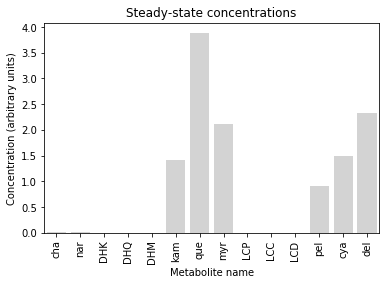

In [18]:
# Check the steady state concentrations
evolving_set.pathway_set[0].plot_ss()